In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import cv2
import numpy as np
from tensorflow import keras
import glob as gb
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


Segmentation Models: using `tf.keras` framework.


In [2]:
# Define root directory and patch size
root_directory = 'Semantic dataset/'
patch_size = 224

In [3]:
# Initialize image and mask datasets
image_dataset = []
mask_dataset = []

In [4]:
afforestation = '#32cd32'.lstrip('#')
afforestation = np.array(tuple(int(afforestation[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

deforestation = '#ff0000'.lstrip('#') 
deforestation = np.array(tuple(int(deforestation[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

degradation =  '#ffa500'.lstrip('#') 
degradation = np.array(tuple(int(degradation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

other_area = '#ffff00'.lstrip('#')
other_area = np.array(tuple(int(other_area[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

forest = '#006400'.lstrip('#') 
forest = np.array(tuple(int(forest[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#808080'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

# Initialize MinMaxScaler for image normalization
scaler = MinMaxScaler()

In [5]:
def rgb_to_2D_label(label):
    
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label==afforestation,axis=-1)] = 0
    label_seg [np.all(label==deforestation,axis=-1)] = 1
    label_seg [np.all(label==degradation,axis=-1)] = 2
    label_seg [np.all(label==forest,axis=-1)] = 3
    label_seg [np.all(label == other_area,axis=-1)] = 4
    label_seg [np.all(label == Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [6]:
# Loop through the directories to process images and masks
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = [f for f in files if f.endswith(".png")]
        for image_name in images:
            image = cv2.imread(os.path.join(path, image_name), 1)
            image = cv2.resize(image, (patch_size, patch_size))  # Resize the image
            image_dataset.append(image)

    elif dirname == 'masks':
        masks = [f for f in files if f.endswith(".png")]
        for mask_name in masks:
            mask = cv2.imread(os.path.join(path, mask_name), 1)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = cv2.resize(mask, (patch_size, patch_size))  # Resize the mask
            mask_dataset.append(mask)

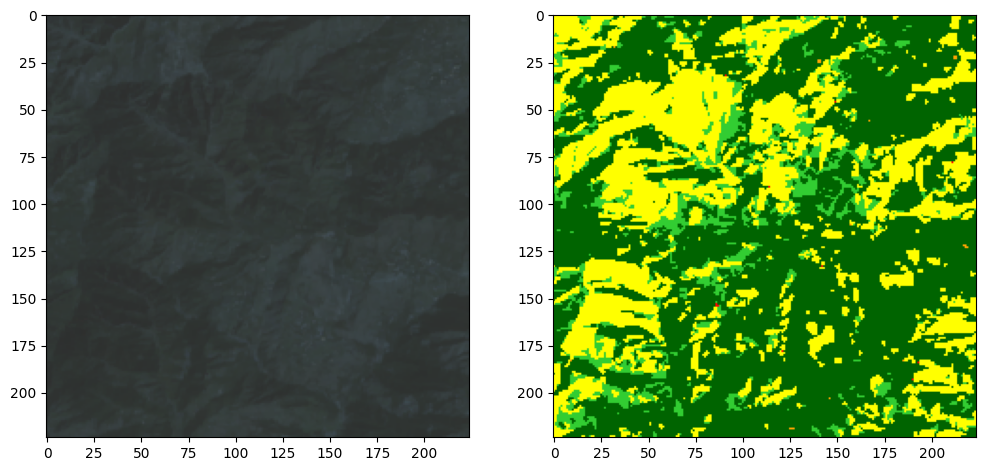

In [7]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

# Visualize a sample image and mask
def visualize_sample(image, mask):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(mask)
    plt.show()

# Choose a random sample for visualization
sample_index = np.random.randint(0, len(image_dataset))
visualize_sample(image_dataset[sample_index], mask_dataset[sample_index])

In [8]:
print("image_dataset: ", image_dataset[sample_index].shape)
print("mask_dataset: ", mask_dataset[sample_index].shape)

image_dataset:  (224, 224, 3)
mask_dataset:  (224, 224, 3)


In [9]:
# Define labels
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

C:\Users\Almadina Computers\AppData\Local\Temp\ipykernel_7304\3381207859.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_name, y=counts, palette=colors)


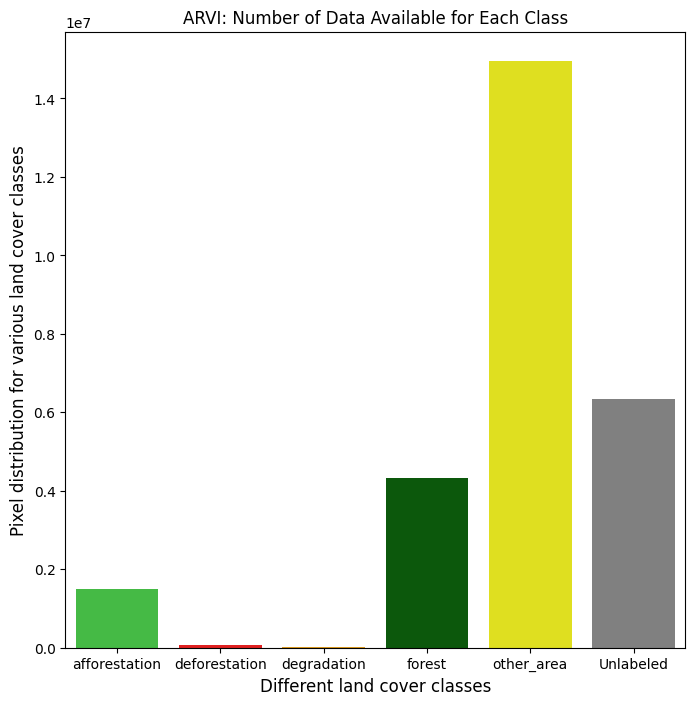

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define class labels
labels_name = ['afforestation', 'deforestation', 'degradation', 'forest', 'other_area', 'Unlabeled']

# Count occurrences of each class label
class_counts = {label: np.sum(labels == label) for label in labels_name}

# Define colors for each class label
color_mapping = {
    'afforestation': '#32cd32',
    'deforestation': '#ff0000',
    'degradation': '#ffa500',
    'forest': '#006400',
    'other_area': '#ffff00',
    'Unlabeled': '#808080'
}

# Extract colors from the color mapping
colors = [color_mapping[label] for label in labels_name]

# Create bar plot
plt.figure(figsize=(8, 8))
sns.barplot(x=labels_name, y=list(class_counts.values()), palette=colors)
plt.title('Distribution of Land Cover Classes')
plt.xlabel('Land Cover Classes', fontsize=12)
plt.ylabel('Number of Pixels', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [11]:
import numpy as np
#from imblearn.over_sampling import SMOTE

# Assuming unique_classes, class_counts, X_balanced, and y_balanced are already defined as in your code
unique_classes, class_counts = np.unique(labels, return_counts=True)
# Print the count of each class label
print("Class distribution before balancing:")
for label, count in zip(unique_classes, class_counts):
    print(f"Class {label}: {count} samples")

Class distribution before balancing:
Class 0: 1482800 samples
Class 1: 69788 samples
Class 2: 17260 samples
Class 3: 4332379 samples
Class 4: 14957256 samples
Class 5: 6335909 samples


In [12]:
# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels.flatten())

In [13]:
image_dataset.shape
# Print unique labels in the label dataset
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


In [14]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.30, random_state=42)

In [15]:
from sklearn.utils import class_weight

# Convert class weights to a dictionary
class_weights_dict = dict(zip(np.unique(image_dataset), class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 3.0567610826364535, 24: 64.9476318755851, 27: 262.6051757435303, 30: 1.0462070223619249, 32: 0.3030345494744045, 33: 0.7153772778828316}


In [16]:
print("Splitted dataset:")
print("  -> Train images: ", X_train.shape)
print("  -> Test images: ", X_test.shape)
print("  -> Train Labels: ", y_train.shape)
print("  -> Test Labels: ", y_test.shape)

Splitted dataset:
  -> Train images:  (379, 224, 224, 3)
  -> Test images:  (163, 224, 224, 3)
  -> Train Labels:  (379, 224, 224, 1)
  -> Test Labels:  (163, 224, 224, 1)


In [17]:
# One-hot encode the labels
n_classes = len(np.unique(labels))
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

In [18]:
#weights = [1.2513186278788484, 34.81060080477314, 150.6937631394534, 0.2850487456306179, 0.6887615031516988, 4.8679117147707975]
dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #

In [19]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
total_classe = y_train.shape[3]
print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)
print(n_classes)

224
224
3
6


In [20]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [21]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [22]:
def unet_model(n_classes=6, IMG_HEIGHT=224, IMG_WIDTH=224, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [23]:
metrics=['accuracy', jacard_coef]

In [24]:
#Using built in keras function for IoU
#from tensorflow.keras.metrics import MeanIoU, Accuracy
#n_classes = 5
#iou= MeanIoU(num_classes=n_classes)  

In [25]:
def get_model():
    return unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [26]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 224, 224, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 16)         2320      ['dropout[0][0]']             
                                                                                           

In [27]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 8, 
                    verbose=1, 
                    epochs=5, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Epoch 1/5


48/48 [==============================] - 82s 1s/step - loss: 1.4140 - accuracy: 0.2079 - jacard_coef: 0.1040 - val_loss: 1.4378 - val_accuracy: 0.2279 - val_jacard_coef: 0.1275
Epoch 2/5
48/48 [==============================] - 67s 1s/step - loss: 1.4380 - accuracy: 0.2130 - jacard_coef: 0.1257 - val_loss: 1.4404 - val_accuracy: 0.2182 - val_jacard_coef: 0.1210
Epoch 3/5
48/48 [==============================] - 67s 1s/step - loss: 1.4475 - accuracy: 0.2016 - jacard_coef: 0.1168 - val_loss: 1.3186 - val_accuracy: 0.2365 - val_jacard_coef: 0.1212
Epoch 4/5
48/48 [==============================] - 68s 1s/step - loss: 1.3649 - accuracy: 0.2744 - jacard_coef: 0.1599 - val_loss: 1.2695 - val_accuracy: 0.4162 - val_jacard_coef: 0.2569
Epoch 5/5
48/48 [==============================] - 67s 1s/step - loss: 1.2466 - accuracy: 0.4306 - jacard_coef: 0.2628 - val_loss: 1.2882 - val_accuracy: 0.2658 - val_jacard_coef: 0.1519


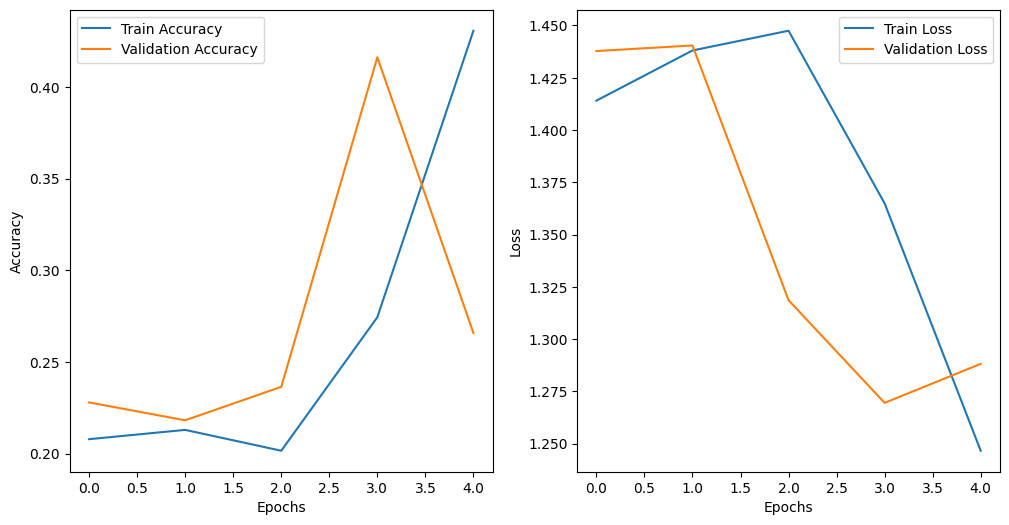

In [28]:
# Visualize training history
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

In [29]:
# Evaluate the model
score = model.evaluate(X_test, y_test_cat)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

6/6 [==============================] - 7s 1s/step - loss: 1.2858 - accuracy: 0.2658 - jacard_coef: 0.1343
Test Loss: 1.2858057022094727
Test Accuracy: 0.26582038402557373


In [30]:
#import skimage
#y_test = skimage.img_as_float(y_test.astype(np.uint8))


In [31]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test_cat, axis=3)

6/6 [==============================] - 6s 911ms/step


In [32]:
len(y_pred_argmax)

163

In [33]:
y_pred_argmax

array([[[2, 5, 2, ..., 2, 5, 5],
        [2, 5, 2, ..., 2, 4, 5],
        [2, 5, 2, ..., 2, 3, 5],
        ...,
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5]],

       [[2, 5, 2, ..., 5, 5, 5],
        [2, 5, 5, ..., 5, 5, 5],
        [2, 5, 3, ..., 5, 5, 5],
        ...,
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5]],

       [[2, 5, 2, ..., 5, 5, 5],
        [2, 5, 5, ..., 2, 4, 5],
        [2, 5, 3, ..., 2, 3, 5],
        ...,
        [2, 5, 5, ..., 2, 4, 5],
        [2, 2, 3, ..., 2, 2, 5],
        [5, 5, 4, ..., 5, 4, 5]],

       ...,

       [[2, 5, 2, ..., 2, 5, 5],
        [2, 5, 5, ..., 2, 4, 5],
        [2, 5, 2, ..., 2, 3, 5],
        ...,
        [2, 5, 5, ..., 2, 4, 5],
        [2, 2, 3, ..., 2, 3, 4],
        [5, 5, 4, ..., 2, 4, 5]],

       [[2, 5, 2, ..., 2, 5, 5],
        [2, 5, 5, ..., 5, 4, 5],
        [2, 2, 2, ..., 2, 3, 5],
        ...,
        [2, 5, 5, ..., 

In [34]:
len(y_test_argmax)

163

In [35]:
y_test_argmax

array([[[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5]],

       [[4, 4, 4, ..., 5, 5, 5],
        [4, 4, 4, ..., 5, 5, 5],
        [4, 4, 4, ..., 5, 5, 5],
        ...,
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       ...,

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 

In [36]:
# Compute confusion matrix
conf_matrix = np.zeros((n_classes, n_classes))
for i in range(len(y_test_argmax)):
    for j in range(len(y_test_argmax[i])):
        conf_matrix[y_test_argmax[i, j], y_pred_argmax[i, j]] += 1

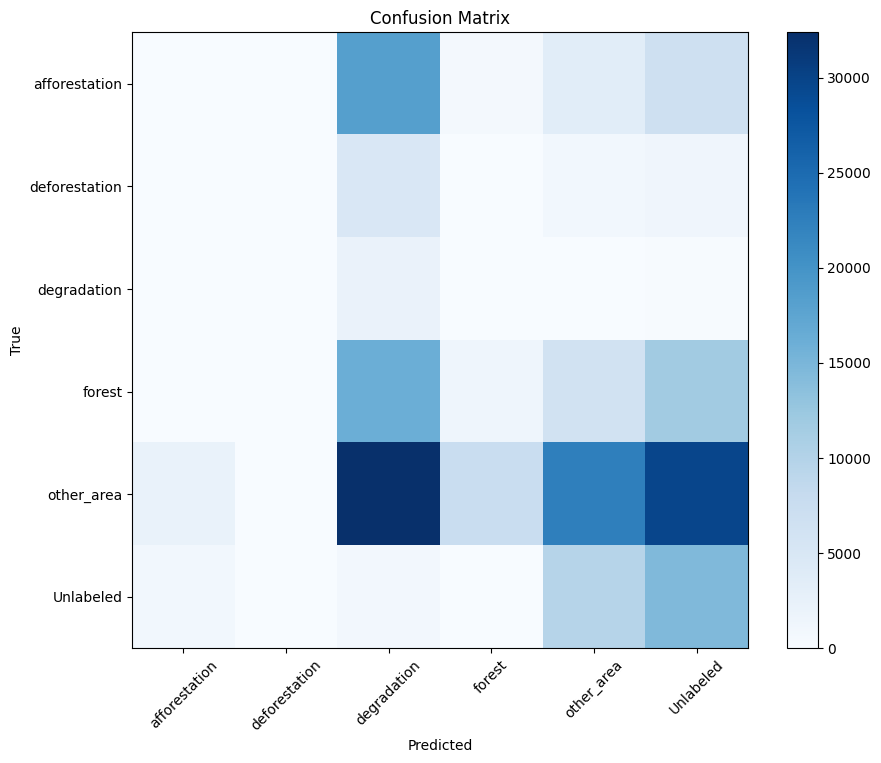

In [38]:
label_classes=['afforestation', 'deforestation', 'degradation', 'forest', 'other_area', 'Unlabeled']
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(len(label_classes)), label_classes, rotation=45)
plt.yticks(np.arange(len(label_classes)), label_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [39]:
# Compute class-wise accuracy
class_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
for i, label in enumerate(label_classes):
    print(f'Accuracy for {label}: {class_accuracy[i]:.2%}')

Accuracy for afforestation: 0.12%
Accuracy for deforestation: 0.00%
Accuracy for degradation: 87.97%
Accuracy for forest: 4.17%
Accuracy for other_area: 23.80%
Accuracy for Unlabeled: 55.90%


In [40]:
num_samples = 10
test_img_numbers = random.sample(range(X_test.shape[0]), num_samples)
for test_img_number in test_img_numbers:
    test_img = X_test[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    #test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth, vmin=0, vmax = n_classes)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, vmin=0, vmax = n_classes)
    plt.show()

NameError: name 'random' is not defined